# Objective:

In this competition, in addition to traditional forecasting methods, you’re also challenged to use machine learning to improve forecast accuracy.

In this competition, the fifth iteration, you will use hierarchical sales data from Walmart, the world’s largest company by revenue, to forecast daily sales for the next 28 days and to make uncertainty estimates for these forecasts. The data, cover stores in three US states (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy.

**In the challenge, you are predicting 9 quartiles of item sales at stores in various locations for two 28-day time periods. Information about the data is found in the M5 Participants Guide.**


**More specifically, the dataset involves the unit sales of 3,049 products, classified in 3 product categories (Hobbies, Foods, and Household) and 7 product departments, in which the above-mentioned categories are disaggregated**

The products are sold across ten stores, located in three States (CA, TX, and WI)

In [1]:
import pandas as pd
import numpy as np

# plotting data - matplotlib
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
#sales_train_evaluation d1-d1941
#sales_train_validation d1-d1913  =>28 test (validation)
#1969  => 1969-28=1941 (Forecasting)
sales_train = pd.read_csv('sales_train_evaluation.csv')
sales_train

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [3]:
sales_train.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1947)

In [4]:
sales_train=sales_train.drop(['id','item_id','dept_id','store_id'],axis = 1)

In [5]:
sales_train

,cat_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES,CA,0,0,0,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES,CA,0,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES,CA,0,0,0,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES,CA,0,0,0,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES,CA,0,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS,WI,0,0,2,2,0,3,1,4,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS,WI,0,0,0,0,0,5,0,1,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS,WI,0,6,0,2,2,4,1,8,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS,WI,0,0,0,0,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [6]:
sales_train= sales_train.groupby(['state_id','cat_id']).sum()
sales_train

d_1   d_2   d_3   d_4   d_5   d_6   d_7    d_8    d_9  \
state_id cat_id                                                               
CA       FOODS      10101  9862  6944  7864  7178  8256  9005  11870  10977   
         HOBBIES     1802  1561  1472  1405  1181  1459  1314   1986   1482   
         HOUSEHOLD   2292  2382  1692  1778  1566  1607  1932   2754   2237   
TX       FOODS       6853  7030  5124  5470  4602  7067  4671   7055   6920   
         HOBBIES      879   870   526   809   501   831   390    785    794   
         HOUSEHOLD   1706  1730  1128  1102   809  1108  1165   1600   1662   
WI       FOODS       6224  5866  5106  5544  2823  6770  6814   8826   6965   
         HOBBIES     1083   926   684   455   132   930  1240   1215    623   
         HOUSEHOLD   1691  1522  1107   985   354  1183  1479   1841   1076   

                    d_10  ...  d_1932  d_1933  d_1934  d_1935  d_1936  d_1937  \
state_id cat_id           ...                                                   
CA       FOODS      8637  ...   12151   14447   16197   11859   10759   10465   
         HOBBIES    1508  ...    1831    2638    2401    1554    1649    1606   
         HOUSEHOLD  1677  ...    4489    5952    6106    4308    3742    3607   
TX       FOODS      5505  ...    8369    8095   10663    7905    7164    6596   
         HOBBIES     524  ...    1028     933    1461    1205    1199    1056   
         HOUSEHOLD  1290  ...    2923    3338    4125    3118    3007    2723   
WI       FOODS      4759  ...    9587   14034   14587    9394    8225    7729   
         HOBBIES     583  ...    1012    1322    1154     769     781    1078   
         HOUSEHOLD  1089  ...    2683    3549    3227    2250    2251    2236   

                    d_1938  d_1939  d_1940  d_1941  
state_id cat_id                                     
CA       FOODS       10650   11354   14489   15970  
         HOBBIES      1735    1975    2701    2514  
         HOUSEHOLD    3912    4101    5913    6160  
TX       FOODS        6083    7965    8834    9500  
         HOBBIES       830    1132    1440    1543  
         HOUSEHOLD    2249    3206    3407    3772  
WI       FOODS        8004    8817   10276   10497  
         HOBBIES       910    1036    1192    1223  
         HOUSEHOLD    2590    2966    3266    3159  

[9 rows x 1941 columns]

In [7]:
sales_train = sales_train.reset_index()
sales_train

,state_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA,FOODS,10101,9862,6944,7864,7178,8256,9005,11870,...,12151,14447,16197,11859,10759,10465,10650,11354,14489,15970
1,CA,HOBBIES,1802,1561,1472,1405,1181,1459,1314,1986,...,1831,2638,2401,1554,1649,1606,1735,1975,2701,2514
2,CA,HOUSEHOLD,2292,2382,1692,1778,1566,1607,1932,2754,...,4489,5952,6106,4308,3742,3607,3912,4101,5913,6160
3,TX,FOODS,6853,7030,5124,5470,4602,7067,4671,7055,...,8369,8095,10663,7905,7164,6596,6083,7965,8834,9500
4,TX,HOBBIES,879,870,526,809,501,831,390,785,...,1028,933,1461,1205,1199,1056,830,1132,1440,1543
5,TX,HOUSEHOLD,1706,1730,1128,1102,809,1108,1165,1600,...,2923,3338,4125,3118,3007,2723,2249,3206,3407,3772
6,WI,FOODS,6224,5866,5106,5544,2823,6770,6814,8826,...,9587,14034,14587,9394,8225,7729,8004,8817,10276,10497
7,WI,HOBBIES,1083,926,684,455,132,930,1240,1215,...,1012,1322,1154,769,781,1078,910,1036,1192,1223
8,WI,HOUSEHOLD,1691,1522,1107,985,354,1183,1479,1841,...,2683,3549,3227,2250,2251,2236,2590,2966,3266,3159


In [8]:
sales_train ['State_Catecory'] = sales_train ['state_id']+ '_'+ sales_train['cat_id']
#sales_train['date'] = df['date'].str[1:].astype('int')
sales_train.head(20)

,state_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,State_Catecory
0,CA,FOODS,10101,9862,6944,7864,7178,8256,9005,11870,...,14447,16197,11859,10759,10465,10650,11354,14489,15970,CA_FOODS
1,CA,HOBBIES,1802,1561,1472,1405,1181,1459,1314,1986,...,2638,2401,1554,1649,1606,1735,1975,2701,2514,CA_HOBBIES
2,CA,HOUSEHOLD,2292,2382,1692,1778,1566,1607,1932,2754,...,5952,6106,4308,3742,3607,3912,4101,5913,6160,CA_HOUSEHOLD
3,TX,FOODS,6853,7030,5124,5470,4602,7067,4671,7055,...,8095,10663,7905,7164,6596,6083,7965,8834,9500,TX_FOODS
4,TX,HOBBIES,879,870,526,809,501,831,390,785,...,933,1461,1205,1199,1056,830,1132,1440,1543,TX_HOBBIES
5,TX,HOUSEHOLD,1706,1730,1128,1102,809,1108,1165,1600,...,3338,4125,3118,3007,2723,2249,3206,3407,3772,TX_HOUSEHOLD
6,WI,FOODS,6224,5866,5106,5544,2823,6770,6814,8826,...,14034,14587,9394,8225,7729,8004,8817,10276,10497,WI_FOODS
7,WI,HOBBIES,1083,926,684,455,132,930,1240,1215,...,1322,1154,769,781,1078,910,1036,1192,1223,WI_HOBBIES
8,WI,HOUSEHOLD,1691,1522,1107,985,354,1183,1479,1841,...,3549,3227,2250,2251,2236,2590,2966,3266,3159,WI_HOUSEHOLD


In [9]:
sales_train = sales_train.set_index('State_Catecory')
sales_train

,state_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
State_Catecory,,,,,,,,,,,,,,,,,,,,,
CA_FOODS,CA,FOODS,10101,9862,6944,7864,7178,8256,9005,11870,...,12151,14447,16197,11859,10759,10465,10650,11354,14489,15970
CA_HOBBIES,CA,HOBBIES,1802,1561,1472,1405,1181,1459,1314,1986,...,1831,2638,2401,1554,1649,1606,1735,1975,2701,2514
CA_HOUSEHOLD,CA,HOUSEHOLD,2292,2382,1692,1778,1566,1607,1932,2754,...,4489,5952,6106,4308,3742,3607,3912,4101,5913,6160
TX_FOODS,TX,FOODS,6853,7030,5124,5470,4602,7067,4671,7055,...,8369,8095,10663,7905,7164,6596,6083,7965,8834,9500
TX_HOBBIES,TX,HOBBIES,879,870,526,809,501,831,390,785,...,1028,933,1461,1205,1199,1056,830,1132,1440,1543
TX_HOUSEHOLD,TX,HOUSEHOLD,1706,1730,1128,1102,809,1108,1165,1600,...,2923,3338,4125,3118,3007,2723,2249,3206,3407,3772
WI_FOODS,WI,FOODS,6224,5866,5106,5544,2823,6770,6814,8826,...,9587,14034,14587,9394,8225,7729,8004,8817,10276,10497
WI_HOBBIES,WI,HOBBIES,1083,926,684,455,132,930,1240,1215,...,1012,1322,1154,769,781,1078,910,1036,1192,1223
WI_HOUSEHOLD,WI,HOUSEHOLD,1691,1522,1107,985,354,1183,1479,1841,...,2683,3549,3227,2250,2251,2236,2590,2966,3266,3159


In [10]:
sales_train=sales_train.drop(['state_id','cat_id'],axis = 1)
sales_train

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
State_Catecory,,,,,,,,,,,,,,,,,,,,,
CA_FOODS,10101,9862,6944,7864,7178,8256,9005,11870,10977,8637,...,12151,14447,16197,11859,10759,10465,10650,11354,14489,15970
CA_HOBBIES,1802,1561,1472,1405,1181,1459,1314,1986,1482,1508,...,1831,2638,2401,1554,1649,1606,1735,1975,2701,2514
CA_HOUSEHOLD,2292,2382,1692,1778,1566,1607,1932,2754,2237,1677,...,4489,5952,6106,4308,3742,3607,3912,4101,5913,6160
TX_FOODS,6853,7030,5124,5470,4602,7067,4671,7055,6920,5505,...,8369,8095,10663,7905,7164,6596,6083,7965,8834,9500
TX_HOBBIES,879,870,526,809,501,831,390,785,794,524,...,1028,933,1461,1205,1199,1056,830,1132,1440,1543
TX_HOUSEHOLD,1706,1730,1128,1102,809,1108,1165,1600,1662,1290,...,2923,3338,4125,3118,3007,2723,2249,3206,3407,3772
WI_FOODS,6224,5866,5106,5544,2823,6770,6814,8826,6965,4759,...,9587,14034,14587,9394,8225,7729,8004,8817,10276,10497
WI_HOBBIES,1083,926,684,455,132,930,1240,1215,623,583,...,1012,1322,1154,769,781,1078,910,1036,1192,1223
WI_HOUSEHOLD,1691,1522,1107,985,354,1183,1479,1841,1076,1089,...,2683,3549,3227,2250,2251,2236,2590,2966,3266,3159


In [11]:
sales_train=sales_train.T
sales_train

State_Catecory,CA_FOODS,CA_HOBBIES,CA_HOUSEHOLD,TX_FOODS,TX_HOBBIES,TX_HOUSEHOLD,WI_FOODS,WI_HOBBIES,WI_HOUSEHOLD
d_1,10101,1802,2292,6853,879,1706,6224,1083,1691
d_2,9862,1561,2382,7030,870,1730,5866,926,1522
d_3,6944,1472,1692,5124,526,1128,5106,684,1107
d_4,7864,1405,1778,5470,809,1102,5544,455,985
d_5,7178,1181,1566,4602,501,809,2823,132,354
...,...,...,...,...,...,...,...,...,...
d_1937,10465,1606,3607,6596,1056,2723,7729,1078,2236
d_1938,10650,1735,3912,6083,830,2249,8004,910,2590
d_1939,11354,1975,4101,7965,1132,3206,8817,1036,2966
d_1940,14489,2701,5913,8834,1440,3407,10276,1192,3266


In [12]:
DatetimeIndex = pd.date_range('29/01/2011','22/05/2016')
DatetimeIndex

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', length=1941, freq='D')

In [13]:
sales_train['Date']= DatetimeIndex
sales_train = sales_train.set_index('Date')
sales_train

State_Catecory,CA_FOODS,CA_HOBBIES,CA_HOUSEHOLD,TX_FOODS,TX_HOBBIES,TX_HOUSEHOLD,WI_FOODS,WI_HOBBIES,WI_HOUSEHOLD
Date,,,,,,,,,
2011-01-29,10101,1802,2292,6853,879,1706,6224,1083,1691
2011-01-30,9862,1561,2382,7030,870,1730,5866,926,1522
2011-01-31,6944,1472,1692,5124,526,1128,5106,684,1107
2011-02-01,7864,1405,1778,5470,809,1102,5544,455,985
2011-02-02,7178,1181,1566,4602,501,809,2823,132,354
...,...,...,...,...,...,...,...,...,...
2016-05-18,10465,1606,3607,6596,1056,2723,7729,1078,2236
2016-05-19,10650,1735,3912,6083,830,2249,8004,910,2590
2016-05-20,11354,1975,4101,7965,1132,3206,8817,1036,2966


In [14]:
sales_train = sales_train.reset_index()
sales_train

State_Catecory,Date,CA_FOODS,CA_HOBBIES,CA_HOUSEHOLD,TX_FOODS,TX_HOBBIES,TX_HOUSEHOLD,WI_FOODS,WI_HOBBIES,WI_HOUSEHOLD
0,2011-01-29,10101,1802,2292,6853,879,1706,6224,1083,1691
1,2011-01-30,9862,1561,2382,7030,870,1730,5866,926,1522
2,2011-01-31,6944,1472,1692,5124,526,1128,5106,684,1107
3,2011-02-01,7864,1405,1778,5470,809,1102,5544,455,985
4,2011-02-02,7178,1181,1566,4602,501,809,2823,132,354
...,...,...,...,...,...,...,...,...,...,...
1936,2016-05-18,10465,1606,3607,6596,1056,2723,7729,1078,2236
1937,2016-05-19,10650,1735,3912,6083,830,2249,8004,910,2590
1938,2016-05-20,11354,1975,4101,7965,1132,3206,8817,1036,2966
1939,2016-05-21,14489,2701,5913,8834,1440,3407,10276,1192,3266


In [15]:
#def  get_ymd (Date):

    #Y,M,D=[],[],[]
    
    #for i in range(len(Date)):
        #oneday=Date[i]
        #year=oneday.year
        #month=oneday.month
        #day=oneday.day

        #Y.append(year)
        #M.append(month)
        #D.append(day)
        
        #date= pd.sales_train()
        
        #date['year']=Y
        #date['month']=M
        #date['day']=D
    
    #return date

In [16]:
sales_train['Year']= sales_train['Date'].dt.year
sales_train['Month']= sales_train['Date'].dt.month

In [17]:
sales_train.columns

Index(['Date', 'CA_FOODS', 'CA_HOBBIES', 'CA_HOUSEHOLD', 'TX_FOODS',
       'TX_HOBBIES', 'TX_HOUSEHOLD', 'WI_FOODS', 'WI_HOBBIES', 'WI_HOUSEHOLD',
       'Year', 'Month'],
      dtype='object', name='State_Catecory')

In [18]:
sales_train.columns.name = None
sales_train.index.name = None

In [19]:
sales_train

,Date,CA_FOODS,CA_HOBBIES,CA_HOUSEHOLD,TX_FOODS,TX_HOBBIES,TX_HOUSEHOLD,WI_FOODS,WI_HOBBIES,WI_HOUSEHOLD,Year,Month
0,2011-01-29,10101,1802,2292,6853,879,1706,6224,1083,1691,2011,1
1,2011-01-30,9862,1561,2382,7030,870,1730,5866,926,1522,2011,1
2,2011-01-31,6944,1472,1692,5124,526,1128,5106,684,1107,2011,1
3,2011-02-01,7864,1405,1778,5470,809,1102,5544,455,985,2011,2
4,2011-02-02,7178,1181,1566,4602,501,809,2823,132,354,2011,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1936,2016-05-18,10465,1606,3607,6596,1056,2723,7729,1078,2236,2016,5
1937,2016-05-19,10650,1735,3912,6083,830,2249,8004,910,2590,2016,5
1938,2016-05-20,11354,1975,4101,7965,1132,3206,8817,1036,2966,2016,5
1939,2016-05-21,14489,2701,5913,8834,1440,3407,10276,1192,3266,2016,5


In [20]:
#1941 days become 65 month
sales_train= sales_train.groupby(['Year','Month']).mean()
sales_train

CA_FOODS   CA_HOBBIES  CA_HOUSEHOLD     TX_FOODS   TX_HOBBIES  \
Year Month                                                                      
2011 1       8969.000000  1611.666667   2122.000000  6335.666667   758.333333   
     2       7966.892857  1422.321429   1971.535714  5541.035714   636.892857   
     3       7495.870968  1403.290323   2058.193548  5314.870968   596.741935   
     4       7439.200000  1452.300000   2141.966667  5304.900000   664.900000   
     5       6893.709677  1415.419355   2063.967742  5135.387097   690.225806   
...                  ...          ...           ...          ...          ...   
2016 1      10946.774194  1916.096774   4085.258065  6604.677419   988.516129   
     2      11328.586207  1886.413793   4223.068966  7212.241379  1058.551724   
     3      11334.516129  1833.709677   4216.612903  7159.677419   992.387097   
     4      11753.000000  1919.666667   4492.666667  7261.366667  1105.633333   
     5      12454.227273  2014.363636   4605.363636  7914.181818  1141.136364   

            TX_HOUSEHOLD      WI_FOODS   WI_HOBBIES  WI_HOUSEHOLD  
Year Month                                                         
2011 1       1521.333333   5732.000000   897.666667   1440.000000  
     2       1394.035714   5072.428571   703.714286   1233.107143  
     3       1351.677419   4444.548387   699.677419   1266.322581  
     4       1386.233333   4241.500000   756.100000   1203.333333  
     5       1323.419355   3833.903226   714.129032   1141.516129  
...                  ...           ...          ...           ...  
2016 1       2787.129032   8495.000000   887.419355   2491.903226  
     2       3043.344828   9208.793103   949.482759   2914.586207  
     3       2934.193548   9101.096774   923.612903   2657.290323  
     4       2873.866667   9584.366667  1015.266667   2776.500000  
     5       2977.318182  10396.954545  1010.772727   2712.136364  

[65 rows x 9 columns]

# Simple moving average

### Build the model

##### For CA Foods:

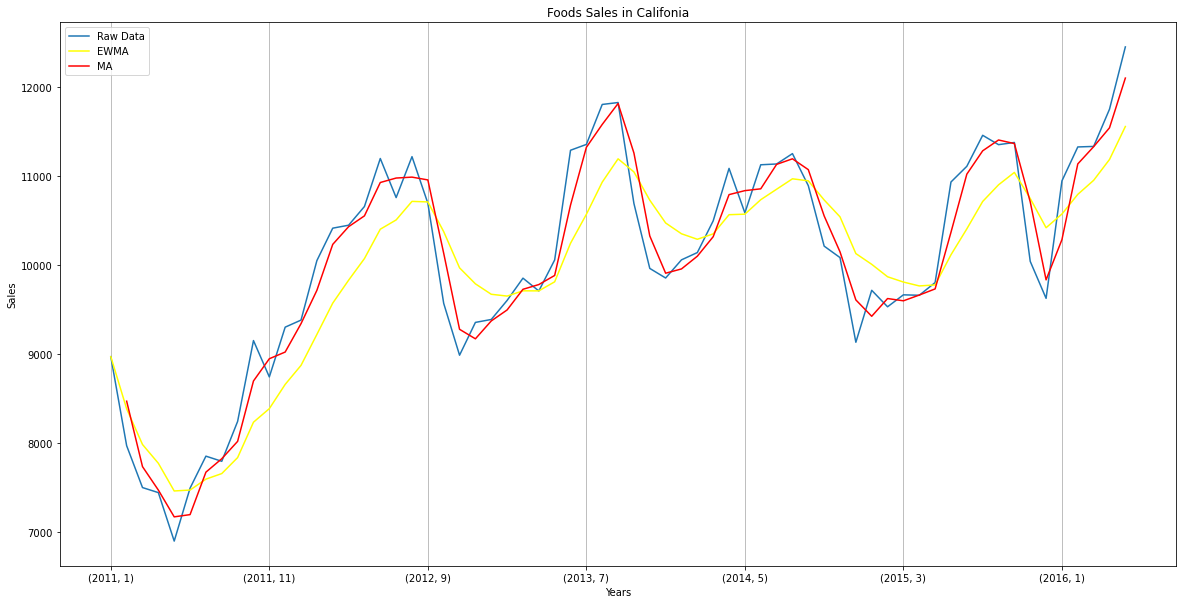

In [21]:
sales_train['MA_CA_FOODS'] = sales_train.CA_FOODS.rolling(window=2).mean()
sales_train['EWMA_CA_FOODS']=pd.DataFrame.ewm(sales_train.CA_FOODS,halflife=2).mean()

sales_train['CA_FOODS'].plot(figsize=(20,10),legend=True,label='Raw Data')
sales_train['EWMA_CA_FOODS'].plot(color='yellow',figsize=(20,10),legend=True,label='EWMA')
sales_train['MA_CA_FOODS'].plot(color='red',figsize=(20,10),legend=True,label='MA')

plt.title("Foods Sales in Califonia")
plt.xlabel("Years")
plt.ylabel("Sales")
plt.grid(axis = 'x')

In [22]:
#65*30% = 20
mse_df = sales_train[20:]

In [23]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.CA_FOODS,mse_df.MA_CA_FOODS)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.CA_FOODS,mse_df.MA_CA_FOODS)}')
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.CA_FOODS,mse_df.EWMA_CA_FOODS)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.CA_FOODS,mse_df.EWMA_CA_FOODS)}')

Mean Absolute Error = 214.29213440084402
Mean Squared Error = 82341.24238046071
Mean Absolute Error = 452.7600270770576
Mean Squared Error = 294208.79812055395


In [24]:
sales_train['MA_CA_FOODS']

Year  Month
2011  1                 NaN
      2         8467.946429
      3         7731.381912
      4         7467.535484
      5         7166.454839
                   ...     
2016  1        10285.887097
      2        11137.680200
      3        11331.551168
      4        11543.758065
      5        12103.613636
Name: MA_CA_FOODS, Length: 65, dtype: float64

In [25]:
sales_train['EWMA_CA_FOODS'] 

Year  Month
2011  1         8969.000000
      2         8381.979227
      3         7980.499667
      4         7769.108998
      5         7457.652163
                   ...     
2016  1        10574.037705
      2        10795.039844
      3        10953.048790
      4        11187.349075
      5        11558.409108
Name: EWMA_CA_FOODS, Length: 65, dtype: float64

##### For CA Hobbies:

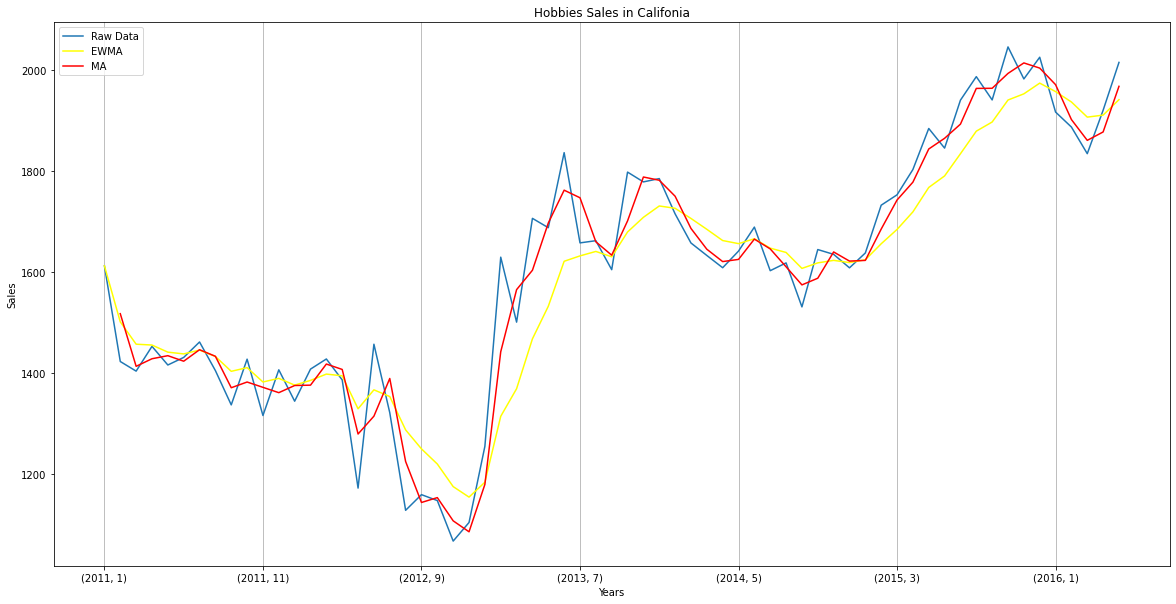

In [26]:
sales_train['MA_CA_HOBBIES'] = sales_train.CA_HOBBIES.rolling(window=2).mean()
sales_train['EWMA_CA_HOBBIES']=pd.DataFrame.ewm(sales_train.CA_HOBBIES,halflife=2).mean()

sales_train['CA_HOBBIES'].plot(figsize=(20,10),legend=True,label='Raw Data')
sales_train['EWMA_CA_HOBBIES'].plot(color='yellow',figsize=(20,10),legend=True,label='EWMA')
sales_train['MA_CA_HOBBIES'].plot(color='red',figsize=(20,10),legend=True,label='MA')

plt.title("Hobbies Sales in Califonia")
plt.xlabel("Years")
plt.ylabel("Sales")
plt.grid(axis = 'x')

In [27]:
#65*30% = 20
mse_df = sales_train[20:]
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.CA_HOBBIES,mse_df.MA_CA_HOBBIES)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.CA_HOBBIES,mse_df.MA_CA_HOBBIES)}')
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.CA_HOBBIES,mse_df.EWMA_CA_HOBBIES)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.CA_HOBBIES,mse_df.EWMA_CA_HOBBIES)}')

Mean Absolute Error = 36.952096386289945
Mean Squared Error = 2502.0626037017128
Mean Absolute Error = 72.44176985291999
Mean Squared Error = 9039.426543017542


In [28]:
sales_train['MA_CA_HOBBIES']

Year  Month
2011  1                NaN
      2        1516.994048
      3        1412.805876
      4        1427.795161
      5        1433.859677
                  ...     
2016  1        1970.338710
      2        1901.255284
      3        1860.061735
      4        1876.688172
      5        1967.015152
Name: MA_CA_HOBBIES, Length: 65, dtype: float64

In [29]:
sales_train['EWMA_CA_HOBBIES'] 

Year  Month
2011  1        1611.666667
      2        1500.750794
      3        1456.593224
      4        1454.916616
      5        1440.863953
                  ...     
2016  1        1956.584038
      2        1936.031649
      3        1906.062237
      4        1910.046882
      5        1940.600552
Name: EWMA_CA_HOBBIES, Length: 65, dtype: float64

##### For CA Househole:

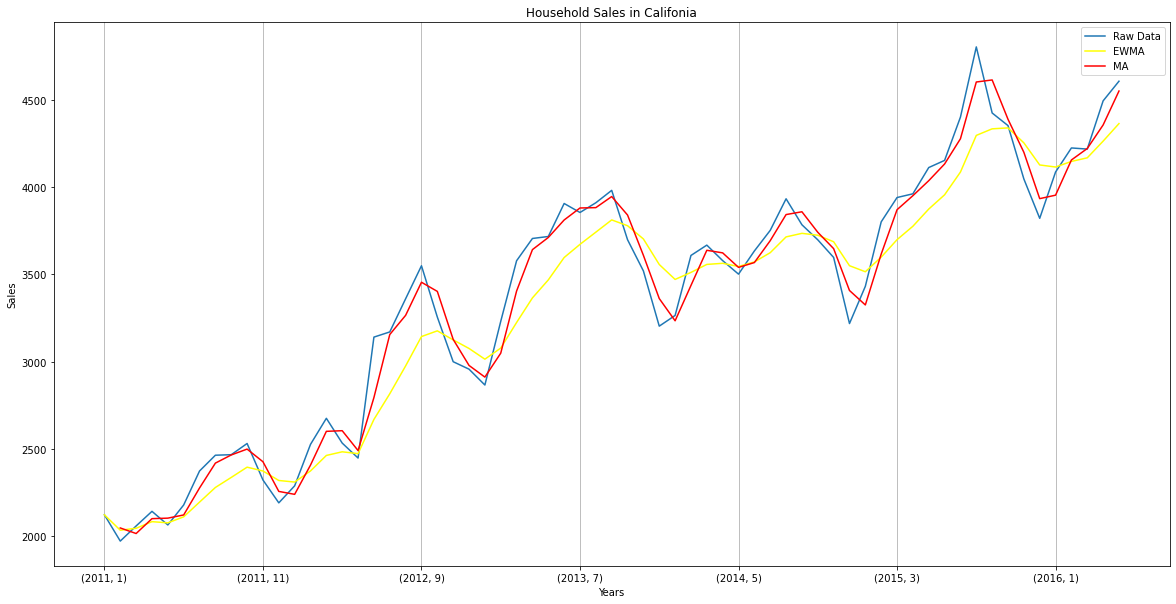

In [30]:
sales_train['MA_CA_HOUSEHOLD'] = sales_train.CA_HOUSEHOLD.rolling(window=2).mean()
sales_train['EWMA_CA_HOUSEHOLD']=pd.DataFrame.ewm(sales_train.CA_HOUSEHOLD,halflife=2).mean()

sales_train['CA_HOUSEHOLD'].plot(figsize=(20,10),legend=True,label='Raw Data')
sales_train['EWMA_CA_HOUSEHOLD'].plot(color='yellow',figsize=(20,10),legend=True,label='EWMA')
sales_train['MA_CA_HOUSEHOLD'].plot(color='red',figsize=(20,10),legend=True,label='MA')

plt.title("Household Sales in Califonia")
plt.xlabel("Years")
plt.ylabel("Sales")
plt.grid(axis = 'x')

In [31]:
#65*30% = 20
mse_df = sales_train[20:]
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.CA_HOUSEHOLD,mse_df.MA_CA_HOUSEHOLD)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.CA_HOUSEHOLD,mse_df.MA_CA_HOUSEHOLD)}')
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.CA_HOUSEHOLD,mse_df.EWMA_CA_HOUSEHOLD)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.CA_HOUSEHOLD,mse_df.EWMA_CA_HOUSEHOLD)}')

Mean Absolute Error = 88.98275337730283
Mean Squared Error = 11290.327113363699
Mean Absolute Error = 178.01514897471822
Mean Squared Error = 44712.680335052006


In [32]:
sales_train['MA_CA_HOUSEHOLD']

Year  Month
2011  1                NaN
      2        2046.767857
      3        2014.864631
      4        2100.080108
      5        2102.967204
                  ...     
2016  1        3952.629032
      2        4154.163515
      3        4219.840934
      4        4354.639785
      5        4549.015152
Name: MA_CA_HOUSEHOLD, Length: 65, dtype: float64

In [33]:
sales_train['EWMA_CA_HOUSEHOLD']

Year  Month
2011  1        2122.000000
      2        2033.860062
      3        2044.885123
      4        2082.797824
      5        2076.098301
                  ...     
2016  1        4113.847512
      2        4145.837735
      3        4166.567302
      4        4262.079595
      5        4362.625163
Name: EWMA_CA_HOUSEHOLD, Length: 65, dtype: float64

##### For TX Foods:

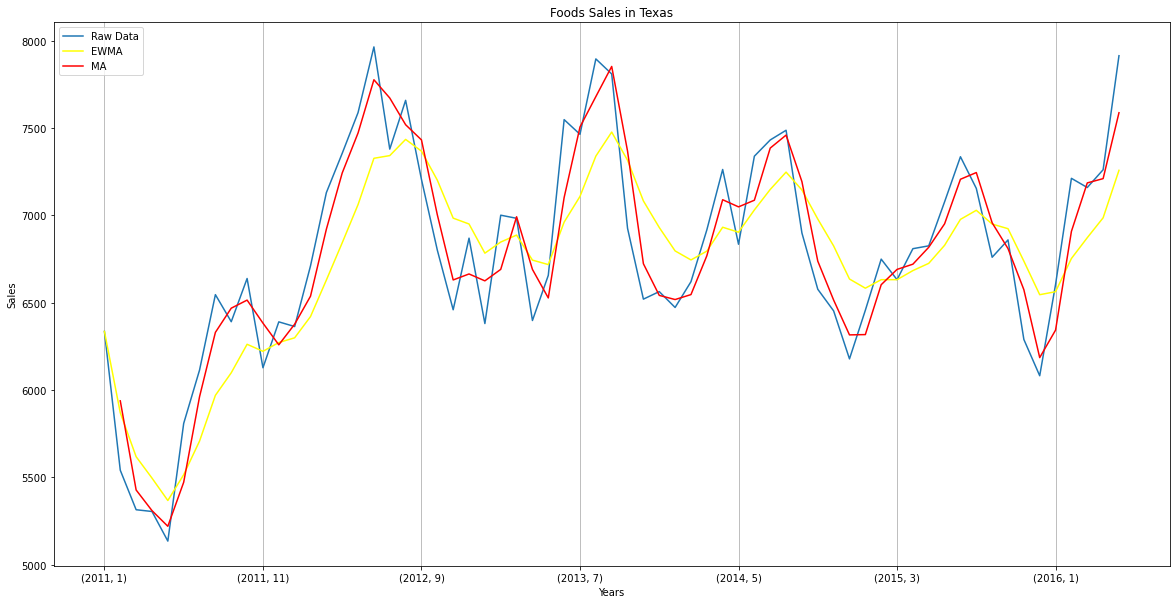

In [34]:
sales_train['MA_TX_FOODS'] = sales_train.TX_FOODS.rolling(window=2).mean()
sales_train['EWMA_TX_FOODS']=pd.DataFrame.ewm(sales_train.TX_FOODS,halflife=2).mean()

sales_train['TX_FOODS'].plot(figsize=(20,10),legend=True,label='Raw Data')
sales_train['EWMA_TX_FOODS'].plot(color='yellow',figsize=(20,10),legend=True,label='EWMA')
sales_train['MA_TX_FOODS'].plot(color='red',figsize=(20,10),legend=True,label='MA')

plt.title("Foods Sales in Texas")
plt.xlabel("Years")
plt.ylabel("Sales")
plt.grid(axis = 'x')

In [35]:
#65*30% = 20
mse_df = sales_train[20:]
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.TX_FOODS,mse_df.MA_TX_FOODS)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.TX_FOODS,mse_df.MA_TX_FOODS)}')
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.TX_FOODS,mse_df.EWMA_TX_FOODS)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.TX_FOODS,mse_df.EWMA_TX_FOODS)}')

Mean Absolute Error = 160.6430148403897
Mean Squared Error = 38019.65883893547
Mean Absolute Error = 283.24077403428623
Mean Squared Error = 107825.07971698724


In [36]:
sales_train['MA_TX_FOODS']

Year  Month
2011  1                NaN
      2        5938.351190
      3        5427.953341
      4        5309.885484
      5        5220.143548
                  ...     
2016  1        6343.338710
      2        6908.459399
      3        7185.959399
      4        7210.522043
      5        7587.774242
Name: MA_TX_FOODS, Length: 65, dtype: float64

In [37]:
sales_train['EWMA_TX_FOODS']

Year  Month
2011  1        6335.666667
      2        5870.182632
      3        5618.581002
      4        5496.080951
      5        5367.750298
                  ...     
2016  1        6563.171305
      2        6753.279529
      3        6872.310715
      4        6986.262565
      5        7258.043822
Name: EWMA_TX_FOODS, Length: 65, dtype: float64

##### For TX Hobbies:

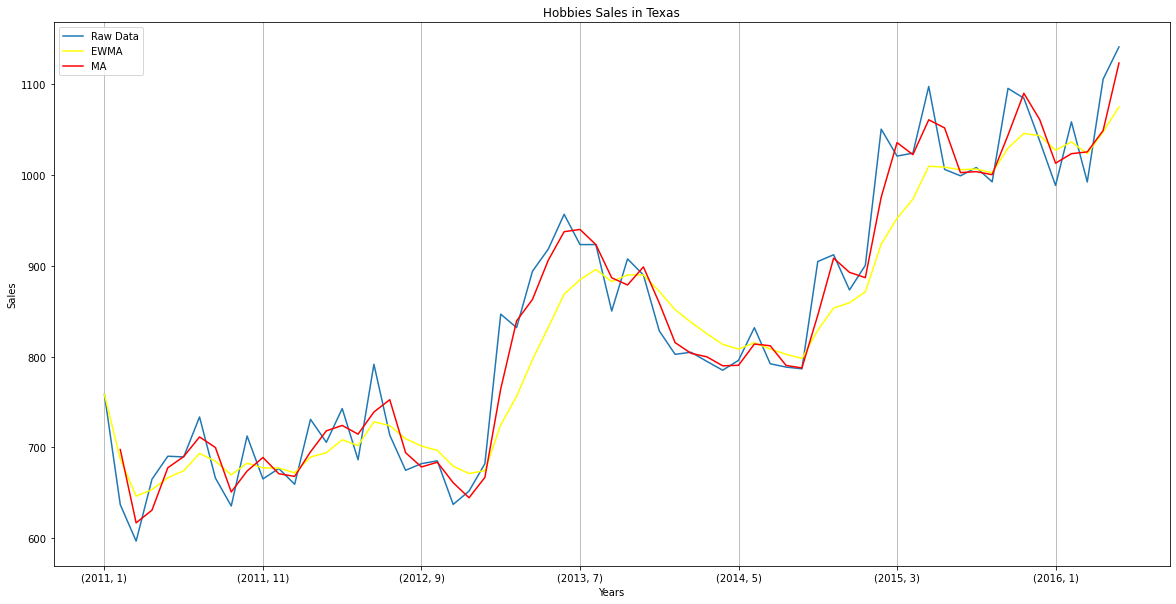

In [38]:
sales_train['MA_TX_HOBBIES'] = sales_train.TX_HOBBIES.rolling(window=2).mean()
sales_train['EWMA_TX_HOBBIES']=pd.DataFrame.ewm(sales_train.TX_HOBBIES,halflife=2).mean()

sales_train['TX_HOBBIES'].plot(figsize=(20,10),legend=True,label='Raw Data')
sales_train['EWMA_TX_HOBBIES'].plot(color='yellow',figsize=(20,10),legend=True,label='EWMA')
sales_train['MA_TX_HOBBIES'].plot(color='red',figsize=(20,10),legend=True,label='MA')

plt.title("Hobbies Sales in Texas")
plt.xlabel("Years")
plt.ylabel("Sales")
plt.grid(axis = 'x')

In [39]:
#65*30% = 20
mse_df = sales_train[20:]
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.TX_HOBBIES,mse_df.MA_TX_HOBBIES)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.TX_HOBBIES,mse_df.MA_TX_HOBBIES)}')
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.TX_HOBBIES,mse_df.EWMA_TX_HOBBIES)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.TX_HOBBIES,mse_df.EWMA_TX_HOBBIES)}')

Mean Absolute Error = 20.635057476614765
Mean Squared Error = 816.7735095405909
Mean Absolute Error = 39.99685818796276
Mean Squared Error = 2615.9576741089118


In [40]:
sales_train['MA_TX_HOBBIES']

Year  Month
2011  1                NaN
      2         697.613095
      3         616.817396
      4         630.820968
      5         677.562903
                  ...     
2016  1        1013.016129
      2        1023.533927
      3        1025.469410
      4        1049.010215
      5        1123.384848
Name: MA_TX_HOBBIES, Length: 65, dtype: float64

In [41]:
sales_train['EWMA_TX_HOBBIES']

Year  Month
2011  1         758.333333
      2         687.195149
      3         646.212441
      4         653.510387
      5         666.573303
                  ...     
2016  1        1027.298067
      2        1036.452051
      3        1023.545725
      4        1047.588629
      5        1074.988126
Name: EWMA_TX_HOBBIES, Length: 65, dtype: float64

##### For TX Househole:

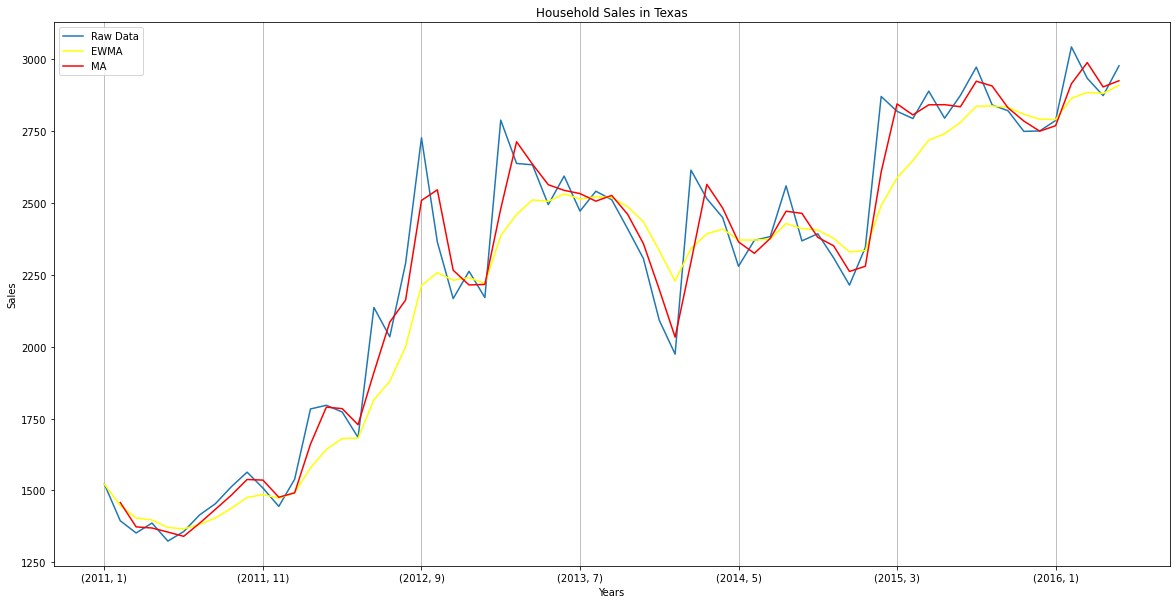

In [42]:
sales_train['MA_TX_HOUSEHOLD'] = sales_train.TX_HOUSEHOLD.rolling(window=2).mean()
sales_train['EWMA_TX_HOUSEHOLD']=pd.DataFrame.ewm(sales_train.TX_HOUSEHOLD,halflife=2).mean()

sales_train['TX_HOUSEHOLD'].plot(figsize=(20,10),legend=True,label='Raw Data')
sales_train['EWMA_TX_HOUSEHOLD'].plot(color='yellow',figsize=(20,10),legend=True,label='EWMA')
sales_train['MA_TX_HOUSEHOLD'].plot(color='red',figsize=(20,10),legend=True,label='MA')

plt.title("Household Sales in Texas")
plt.xlabel("Years")
plt.ylabel("Sales")
plt.grid(axis = 'x')

In [43]:
#65*30% = 20
mse_df = sales_train[20:]
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.TX_HOUSEHOLD,mse_df.MA_TX_HOUSEHOLD)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.TX_HOUSEHOLD,mse_df.MA_TX_HOUSEHOLD)}')
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.TX_HOUSEHOLD,mse_df.EWMA_TX_HOUSEHOLD)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.TX_HOUSEHOLD,mse_df.EWMA_TX_HOUSEHOLD)}')

Mean Absolute Error = 72.14321730467447
Mean Squared Error = 10585.361570823938
Mean Absolute Error = 107.8725420135311
Mean Squared Error = 24494.830497499497


In [44]:
sales_train['MA_TX_HOUSEHOLD']

Year  Month
2011  1                NaN
      2        1457.684524
      3        1372.856567
      4        1368.955376
      5        1354.826344
                  ...     
2016  1        2768.983871
      2        2915.236930
      3        2988.769188
      4        2904.030108
      5        2925.592424
Name: MA_TX_HOUSEHOLD, Length: 65, dtype: float64

In [45]:
sales_train['EWMA_TX_HOUSEHOLD']

Year  Month
2011  1        1521.333333
      2        1446.764115
      3        1403.682060
      4        1396.867908
      5        1370.735772
                  ...     
2016  1        2790.357093
      2        2864.455485
      3        2884.881291
      4        2881.655182
      5        2909.674226
Name: EWMA_TX_HOUSEHOLD, Length: 65, dtype: float64

##### For WI Foods:

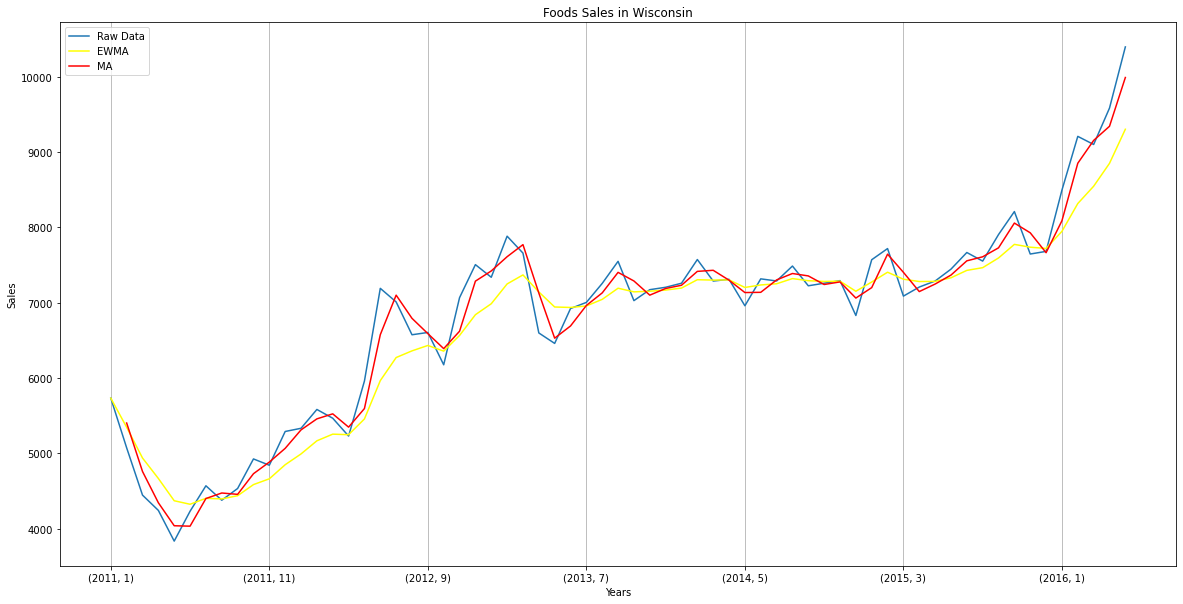

In [46]:
sales_train['MA_WI_FOODS'] = sales_train.WI_FOODS.rolling(window=2).mean()
sales_train['EWMA_WI_FOODS']=pd.DataFrame.ewm(sales_train.WI_FOODS,halflife=2).mean()

sales_train['WI_FOODS'].plot(figsize=(20,10),legend=True,label='Raw Data')
sales_train['EWMA_WI_FOODS'].plot(color='yellow',figsize=(20,10),legend=True,label='EWMA')
sales_train['MA_WI_FOODS'].plot(color='red',figsize=(20,10),legend=True,label='MA')

plt.title("Foods Sales in Wisconsin")
plt.xlabel("Years")
plt.ylabel("Sales")
plt.grid(axis = 'x')

In [47]:
#65*30% = 20
mse_df = sales_train[20:]
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.WI_FOODS,mse_df.MA_WI_FOODS)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.WI_FOODS,mse_df.MA_WI_FOODS)}')
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.WI_FOODS,mse_df.EWMA_WI_FOODS)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.WI_FOODS,mse_df.EWMA_WI_FOODS)}')

Mean Absolute Error = 161.39467024715083
Mean Squared Error = 43389.34139479001
Mean Absolute Error = 266.25454318616966
Mean Squared Error = 136020.78343564138


In [48]:
sales_train['MA_WI_FOODS']

Year  Month
2011  1                NaN
      2        5402.214286
      3        4758.488479
      4        4343.024194
      5        4037.701613
                  ...     
2016  1        8088.225806
      2        8851.896552
      3        9154.944939
      4        9342.731720
      5        9990.660606
Name: MA_WI_FOODS, Length: 65, dtype: float64

In [49]:
sales_train['EWMA_WI_FOODS']

Year  Month
2011  1        5732.000000
      2        5345.632002
      3        4937.367381
      4        4665.614265
      5        4369.701209
                  ...     
2016  1        7947.464414
      2        8316.899034
      3        8546.585234
      4        8850.544379
      5        9303.477430
Name: EWMA_WI_FOODS, Length: 65, dtype: float64

##### For WI Hobbies:

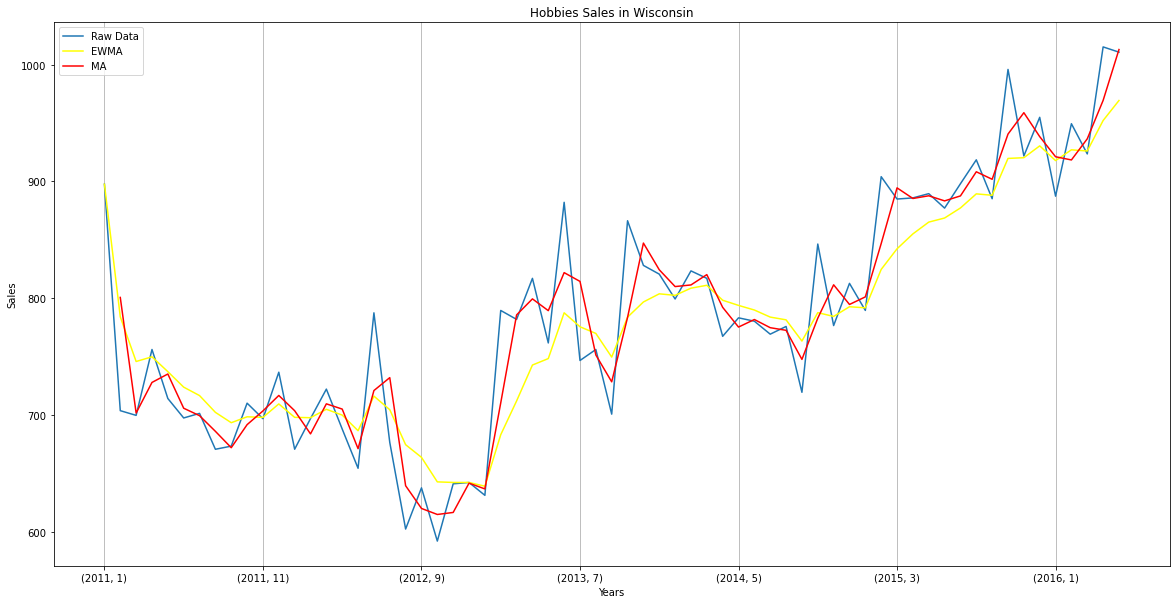

In [50]:
sales_train['MA_WI_HOBBIES'] = sales_train.WI_HOBBIES.rolling(window=2).mean()
sales_train['EWMA_WI_HOBBIES']=pd.DataFrame.ewm(sales_train.WI_HOBBIES,halflife=2).mean()

sales_train['WI_HOBBIES'].plot(figsize=(20,10),legend=True,label='Raw Data')
sales_train['EWMA_WI_HOBBIES'].plot(color='yellow',figsize=(20,10),legend=True,label='EWMA')
sales_train['MA_WI_HOBBIES'].plot(color='red',figsize=(20,10),legend=True,label='MA')

plt.title("Hobbies Sales in Wisconsin")
plt.xlabel("Years")
plt.ylabel("Sales")
plt.grid(axis = 'x')

In [51]:
#65*30% = 20
mse_df = sales_train[20:]
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.WI_HOBBIES,mse_df.MA_WI_HOBBIES)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.WI_HOBBIES,mse_df.MA_WI_HOBBIES)}')
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.WI_HOBBIES,mse_df.EWMA_WI_HOBBIES)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.WI_HOBBIES,mse_df.EWMA_WI_HOBBIES)}')

Mean Absolute Error = 23.065808265396694
Mean Squared Error = 1012.3284851949271
Mean Absolute Error = 31.00479704731873
Mean Squared Error = 1727.768843148139


In [52]:
sales_train['MA_WI_HOBBIES']

Year  Month
2011  1                NaN
      2         800.690476
      3         701.695853
      4         727.888710
      5         735.114516
                  ...     
2016  1         921.193548
      2         918.451057
      3         936.547831
      4         969.439785
      5        1013.019697
Name: MA_WI_HOBBIES, Length: 65, dtype: float64

In [53]:
sales_train['EWMA_WI_HOBBIES']

Year  Month
2011  1        897.666667
      2        784.051992
      3        745.823406
      4        749.836665
      5        737.132307
                  ...    
2016  1        917.884192
      2        927.139198
      3        926.106370
      4        952.220816
      5        969.370274
Name: EWMA_WI_HOBBIES, Length: 65, dtype: float64

##### For WI Household:

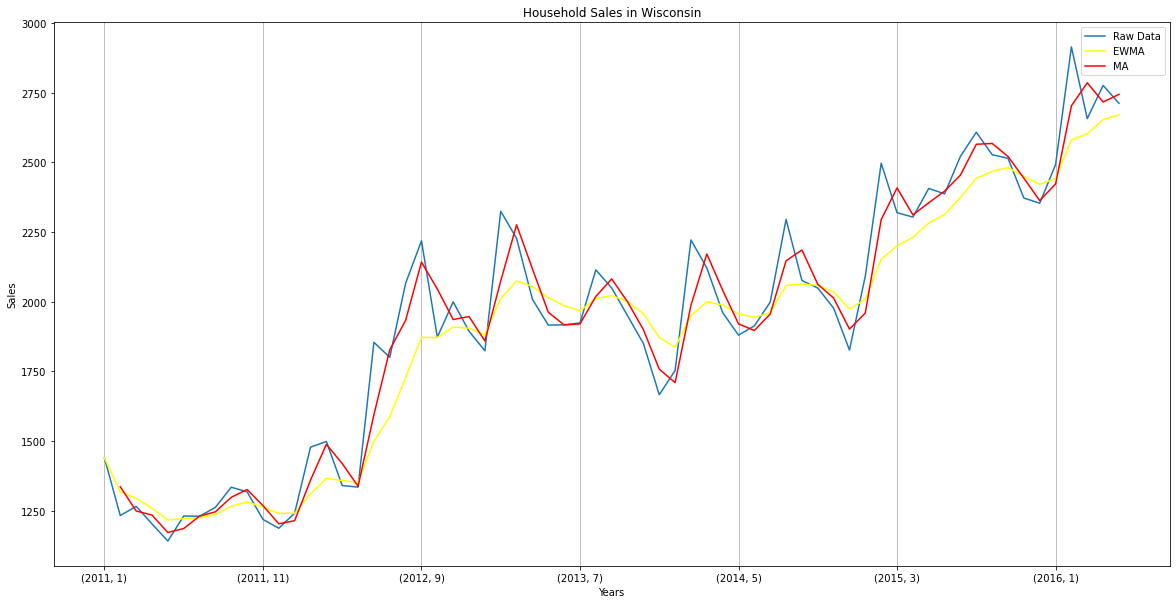

In [54]:
sales_train['MA_WI_HOUSEHOLD'] = sales_train.WI_HOUSEHOLD.rolling(window=2).mean()
sales_train['EWMA_WI_HOUSEHOLD']=pd.DataFrame.ewm(sales_train.WI_HOUSEHOLD,halflife=2).mean()

sales_train['WI_HOUSEHOLD'].plot(figsize=(20,10),legend=True,label='Raw Data')
sales_train['EWMA_WI_HOUSEHOLD'].plot(color='yellow',figsize=(20,10),legend=True,label='EWMA')
sales_train['MA_WI_HOUSEHOLD'].plot(color='red',figsize=(20,10),legend=True,label='MA')

plt.title("Household Sales in Wisconsin")
plt.xlabel("Years")
plt.ylabel("Sales")
plt.grid(axis = 'x')

In [55]:
#65*30% = 20
mse_df = sales_train[20:]
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.WI_HOUSEHOLD,mse_df.MA_WI_HOUSEHOLD)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.WI_HOUSEHOLD,mse_df.MA_WI_HOUSEHOLD)}')
print(f'Mean Absolute Error = {mean_absolute_error(mse_df.WI_HOUSEHOLD,mse_df.EWMA_WI_HOUSEHOLD)}')
print(f'Mean Squared Error = {mean_squared_error(mse_df.WI_HOUSEHOLD,mse_df.EWMA_WI_HOUSEHOLD)}')

Mean Absolute Error = 73.32671562812838
Mean Squared Error = 9109.962765585813
Mean Absolute Error = 106.90925872528715
Mean Squared Error = 19790.108881631968


In [56]:
sales_train['MA_WI_HOUSEHOLD']

Year  Month
2011  1                NaN
      2        1336.553571
      3        1249.714862
      4        1234.827957
      5        1172.424731
                  ...     
2016  1        2422.870968
      2        2703.244716
      3        2785.938265
      4        2716.895161
      5        2744.318182
Name: MA_WI_HOUSEHOLD, Length: 65, dtype: float64

In [57]:
sales_train['EWMA_WI_HOUSEHOLD']

Year  Month
2011  1        1440.000000
      2        1318.804970
      3        1295.026153
      4        1259.217879
      5        1217.340974
                  ...     
2016  1        2442.172894
      2        2580.539550
      3        2603.019331
      4        2653.830642
      5        2670.907993
Name: EWMA_WI_HOUSEHOLD, Length: 65, dtype: float64